# Credit-Card Default Risk
#### by Perry Shyr
## _4-of-7. Modeling with Keras_
![](../images/cards.png)

## Problem Statement

### Credit-card lenders absorb significant losses from consumer defaults.  This capstone revolves around the detection of anomalies in customer demographic and borrowing history to identify credit-card default risk.  It is a binary classification problem with customers who default as the positive class, and unbalanced classes.  For supervised modeling, lenders are probably interested in not just the True-Positive (TP) rate, but also in the False-Negative (FN) and False-Positve (FP) rates. The best Estimator should minimize for both FN's and FP's while generalizing for TP's.

## Executive Summary

### Neural networks have been found to be the best estimators in the literature.

## A. Code Libraries Used

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from sklearn.metrics import confusion_matrix

%matplotlib inline

/Users/perry/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## B. Load Data from Notebook-3

### In the previous notebook of this kernel-series, we added six new features to the cleaned and validated dataset from the first notebook.

In [350]:
accts_nf = pd.read_csv('../assets/credit_new_features.csv', index_col='ID')

### 'X' is the training set containing all the features without the dependent target variable, 'y.'

In [351]:
X = accts_nf.drop(['Oct_Default'], axis=1)

In [352]:
y = accts_nf['Oct_Default']

### C. Validation-splitting and Scaling

### It is necessary to set stratify to ensure that the proportions of the classes present in folds match that in the original target-series.  Scaling is needed because some of the features have small ranges and the others have very large ranges.

In [353]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    stratify=y,
                                                    random_state=42)

In [354]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [367]:
print(X_test_sc.shape)
type(X_test_sc)

(7492, 35)


numpy.ndarray

In [356]:
X_test.head()

,credit_limit,gender,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,leverage_3,leverage_4,leverage_5,leverage_6,bill_to_pay1,bill_to_pay2,bill_to_pay3,bill_to_pay4,bill_to_pay5,bill_to_pay6
ID,,,,,,,,,,,,,,,,,,,,,
7362,150000,2,1,2,30,0,0,0,0,0,...,0.956587,0.949460,0.967333,1.021527,27.251087,29.048462,28.134902,26.871509,13.311927,319999.0000
12267,290000,2,3,2,37,-1,-1,-1,-1,-1,...,0.001366,0.001366,0.001366,0.001366,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000
29379,290000,1,1,2,28,0,0,0,2,2,...,0.030038,0.032445,0.035010,0.033952,5.329167,4.886667,8.711000,10.454444,319999.000000,12.3075
24609,360000,1,1,1,39,-1,-1,2,-1,-1,...,0.000733,0.006092,0.001467,0.000733,0.231782,319999.000000,0.120383,4.153409,319999.000000,1.0000
14979,480000,2,2,2,31,-1,-1,-1,-1,-1,...,0.003665,0.003665,0.003665,0.003665,1.000000,1.000000,1.000000,1.000000,1.000000,1.0000


## D. First Model

### The artificial neural network approach of Keras running TensorFlow in the back end was chosen for initial testing based largely on the original academic [publication](https://bradzzz.gitbooks.io/ga-seattle-dsi/content/dsi/dsi_05_classification_databases/2.1-lesson/assets/datasets/DefaultCreditCardClients_yeh_2009.pdf) that introduced the original dataset in 2009.  In that paper, their neural-network model performed the best on a variation of an AOC-related metric.

### In this notebook, a wide set of hyperparameters was tested manually including:
#### -topologic (number of neurons, number of hidden layers)
#### -features (original set of 23 features and a later set with 12 interaction features)
#### -epochs
#### -batch-size (based a [blog](https://blogs.oracle.com/meena/simple-neural-network-model-using-keras-and-grid-search-hyperparameterstuning) from a literature search)
#### -all available optimizers
#### (James Hampton of GA suggested creating a custom loss-function to minimize for either the False-negative or False-positive rates, but we could not find an online example for making one work)

### The rationale for performing the manual tuning came from relatively few number of epochs needed for convergence and eventual overfitting.

In [359]:
model = Sequential()
model.add(Dense(35, activation='relu', input_dim=X.shape[1]))
model.add(Dense(35, activation='relu', input_dim=X.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid')) # always have 1 neuron, with no activation function

model.compile(loss='logcosh', optimizer='adam', metrics=['accuracy'])
results = model.fit(X_train_sc, y_train,
                    validation_data=(X_test_sc, y_test), verbose=0,
                    epochs=32, batch_size=320)

### The main observation is that not many epochs are needed before convergence and eventual overfitting takes place.  Possibly as few as 9 epochs are needed to see a bottoming of test losses (and topping of test-accuracies). 

### Let's plot the progression of loss reduction through the specified number of epochs.

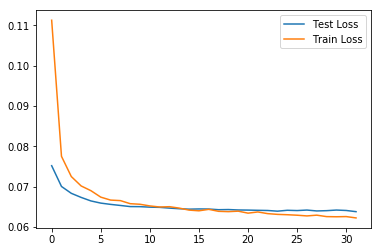

In [360]:
results.history.keys()

plt.plot(results.history['val_loss'], label='Test Loss')
plt.plot(results.history['loss'], label='Train Loss')
plt.legend()

### We can see that with 12 additional features added to the feature-set, the model has started to show overfitting.  From the manual testing, I don't see evidence that adding the extra interaction terms hurts the modeling, so perhaps any collinearity is not having a negative effect.

### With "verbose=1" we can see that the measure of accuracy reaches about 0.82.  Unfortunately, due to lenders' intent for customer retention, they will invariably want to manage their risk exposure from False-negatives.  From a customer service standpoint, they also want to minimize False-positives, so it becomes a balancing act, walking the fine line between disparate commercial interests.  Customers want to feel valued, and business want to curb losses from default.

### Just out of curiosity, let's calculate the percentage difference between our baseline model from Notebook-2 and our current result of 0.82.

In [366]:
baseline = 1-(y.sum()/len(y))
print('percentage lift above baseline of 77.9% is:',(0.8199-(baseline))/baseline)

percentage lift above baseline of 77.9% is: 0.05285208913649029


### There is only a slim margin of separation, probably not enough to be worth reporting.  A 10% lift would be more impressive.

## E. Save the model, splits and scaling:

In [365]:
model.save('../assets/model_keras.h5')

In [ ]:
X.to_csv('../assets/X_processed.csv', index=True)
y.to_csv('../assets/y_target.csv', index=True)

In [ ]:
X_train.to_csv('../assets/X_train_split.csv')
X_test.to_csv('../assets/X_test_split.csv')
y_train.to_csv('../assets/y_train_split.csv')
y_test.to_csv('../assets/y_test_split.csv')

In [ ]:
np.savetxt("../assets/X_train_scaled.csv", X_train_sc, delimiter=",")
np.savetxt("../assets/X_test_scaled.csv", X_test_sc, delimiter=",")

### Let's add the code to save the the split data separately.

In [368]:
X.to_csv('../assets/X_new_features.csv', index=True)

In [369]:
X_train.to_csv('../assets/X_train_split_nf.csv')
X_test.to_csv('../assets/X_test_split_nf.csv')

In [370]:
np.savetxt("../assets/X_train_scaled_nf.csv", X_train_sc, delimiter=",")
np.savetxt("../assets/X_test_scaled_nf.csv", X_test_sc, delimiter=",")

## Continue to Notebook-5, Model Building, Part-2.

### A serious effort was made to target False-Negatives and/or False-Positives optimization.  I learned that adjusting the 'metrics=' input (which I tried) has no effect on any back-propagation process, but serves only to inform the user for reporting purposes.  Also, any gradient descent activity is superfluous because it is already built into the optimization process.

### I was told about possibly using weights to penalize misclassification and about building a custom loss function connected to the backend built on TensorFlow, but I thought I only had time to try a custom loss function based on the formulae for False-Negative and False-Positive rates.  There wasn't an online discussion that I or James Hampton could find to accomplish this.

### I did try the various other available loss functions and found Mean_Squared_Logarithmic_Errors(MSLE)-loss as optimized for penalizing False-Positives, while Logcosh-loss seemed to act in the same way for penalizing False-Negatives.  Based on this manual work.  I would consider the Logcosh-loss function to be the best performing in terms minimizing False-Negatives and maximizing True-positives.  Binary_crossentropy-loss would be a close second-best performer and MSLE the third-best because it does not lift True-Positives. 

### For the next notebook, I would like to show some Grid-searching and a separate TensorFlow neural-network.  That notebook will be followed by more basic/interpretable classification models.

### Finally, in the last notebook I will evaluate all five models for misclassification and inference on the best estimator and best predictors.